## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install pandas
!pip3 install regex
!pip3 install contractions
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install numpy
!pip3 install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import regex as re
import contractions
# stopwords = ENGLISH_STOP_WORDS
# import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import gensim
from sklearn.manifold import TSNE

# plt.xticks(rotation=70)
# pd.options.mode.chained_assignment = None
# pd.set_option('display.max_colwidth', 100)
# %matplotlib inline

## Loading the Dataset

In [4]:
df_reviews = pd.read_json("/content/drive/MyDrive/Data690 Project/yelp_academic_dataset_review.json", encoding = 'ISO-8859-1', lines=True, nrows=100000)
df_business = pd.read_json("/content/drive/MyDrive/Data690 Project/yelp_academic_dataset_business.json", encoding = 'ISO-8859-1', lines=True, nrows=100000)

In [5]:
selected_columns_r = ['business_id', 'stars', 'text']
selected_columns_b = ['business_id','name', 'categories']

In [6]:
dfr = df_reviews[selected_columns_r]
dfb = df_business[selected_columns_b]

In [7]:
dfr.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...


In [8]:
dfb.head()

,business_id,name,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,"Brewpubs, Breweries, Food"


## Sanity Checks

In [9]:
print(dfr.shape)
print(dfb.shape)

(100000, 3)
(100000, 3)


In [10]:
dfb['business_id'].nunique()

100000

In [11]:
dfr.isnull().sum()

business_id    0
stars          0
text           0
dtype: int64

In [12]:
dfb.isnull().sum()

business_id     0
name            0
categories     69
dtype: int64

In [13]:
dfb.isnull().sum()

business_id     0
name            0
categories     69
dtype: int64

In [14]:
dfb = dfb[dfb['categories'].notnull()]

In [15]:
filtered_df = pd.merge(dfr, dfb, on='business_id', how='inner')
filtered_df.head()

,business_id,stars,text,name,categories
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
1,XQfwVwDr-v0ZS3_CbbE5Xw,2,This is the second time we tried turning point...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
2,XQfwVwDr-v0ZS3_CbbE5Xw,4,The place is cute and the staff was very frien...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
3,XQfwVwDr-v0ZS3_CbbE5Xw,3,We came on a Saturday morning after waiting a ...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
4,XQfwVwDr-v0ZS3_CbbE5Xw,2,"Mediocre at best. The decor is very nice, and ...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."


In [16]:
from operator import contains
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
filtered_df['length'] = filtered_df['text'].apply(len)
filtered_df = filtered_df[filtered_df['categories'].str.contains('Restaurants')]
filtered_df.head()

,business_id,stars,text,name,categories,length
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",513
1,XQfwVwDr-v0ZS3_CbbE5Xw,2,This is the second time we tried turning point...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",477
2,XQfwVwDr-v0ZS3_CbbE5Xw,4,The place is cute and the staff was very frien...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",216
3,XQfwVwDr-v0ZS3_CbbE5Xw,3,We came on a Saturday morning after waiting a ...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",736
4,XQfwVwDr-v0ZS3_CbbE5Xw,2,"Mediocre at best. The decor is very nice, and ...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",953


In [17]:
filtered_df['categories'].str.contains('Restaurants')

0        True
1        True
2        True
3        True
4        True
         ... 
99975    True
99976    True
99979    True
99992    True
99994    True
Name: categories, Length: 72124, dtype: bool

Filtering the hospitality and service industries with atleast 10 reviews for better modeling.

In [18]:
product_counts = filtered_df['name'].value_counts()
final_index = product_counts[product_counts > 10].index
df_final = filtered_df[filtered_df['name'].isin(final_index)]
df_final

,business_id,stars,text,name,categories,length
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",513
1,XQfwVwDr-v0ZS3_CbbE5Xw,2,This is the second time we tried turning point...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",477
2,XQfwVwDr-v0ZS3_CbbE5Xw,4,The place is cute and the staff was very frien...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",216
3,XQfwVwDr-v0ZS3_CbbE5Xw,3,We came on a Saturday morning after waiting a ...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",736
4,XQfwVwDr-v0ZS3_CbbE5Xw,2,"Mediocre at best. The decor is very nice, and ...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",953
...,...,...,...,...,...,...
99943,wgcSbX3osqRibWW7pVyfww,2,I don't mind fast food restaurants and I gener...,Jack in the Box,"Burgers, Fast Food, Restaurants, Breakfast & B...",613
99950,9IPELhqCGHHrn9vCB15eJQ,1,Supposedly this Burger King is open until midn...,Burger King,"Burgers, Restaurants, Fast Food",199
99969,VNIIbbmezbdiwcldBtW8Pw,1,So... very interesting experience wow.. where ...,Dairy Queen Grill & Chill,"Food, Fast Food, Restaurants, Ice Cream & Froz...",1419
99976,-v0JE4wW_4Xs6C3WT2XgDA,3,"It is what it is .......\nSafe, clean food.\nE...",Burger King,"Restaurants, Fast Food, Food, Burgers",155


# Exploratory Data Analysis

In [19]:
# Basic Statistics
print(filtered_df.describe())

              stars        length
count  72124.000000  72124.000000
mean       3.810840    537.376338
std        1.323342    496.479036
min        1.000000      3.000000
25%        3.000000    218.000000
50%        4.000000    382.000000
75%        5.000000    679.000000
max        5.000000   5000.000000


### Example of a Restaurant Review and Star Rating

In [20]:
print('Name:', filtered_df['name'][15])
print('\nReview:', filtered_df['text'][15])
print('\nStars:',filtered_df['stars'][15])

Name: Turning Point of North Wales

Review: Went here over the weekend,  got my sugar rush on with the salted caramel waffles.  Awesome!!!  Staff was happy and helpful, noticed that kids got a little cup of fruitloops if they were waiting for a table. That's a nice touch for families.  The coffee was fantastic, parking was tough as the plaza is very congested.  Good place!

Stars: 5


## Distribution of reviews across categories

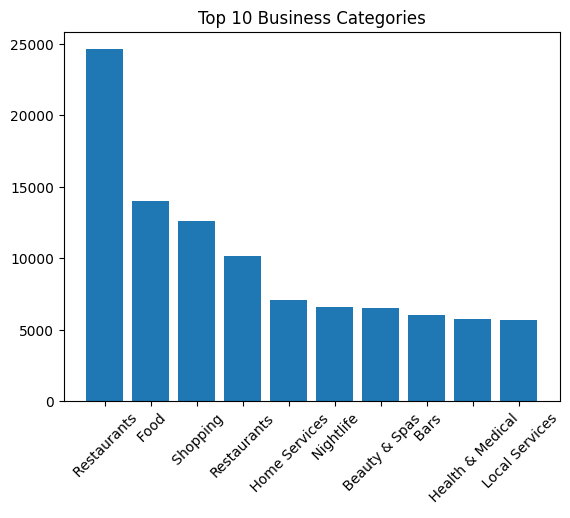

In [21]:
from collections import Counter
all_categories = ','.join(dfb['categories'].dropna()).split(',')
category_counts = Counter(all_categories)
most_common_categories = category_counts.most_common(10)
plt.bar(*zip(*most_common_categories))
plt.xticks(rotation=45)
plt.title('Top 10 Business Categories')
plt.show()


## Distrbution of Reviews Across Restaurants

In [22]:
product_counts = filtered_df['name'].value_counts()
product_counts

Luke                            950
Mr. B's Bistro                  433
Surrey's CafÃ© & Juice Bar      404
The Pancake Pantry              384
District Donuts Sliders Brew    365
                               ... 
La Cocina Dominicana              1
Grill At Fore                     1
Gelato Irpino Media               1
Fratelli                          1
Stoogez                           1
Name: name, Length: 3409, dtype: int64

## Distrbution of Ratings

<Axes: title={'center': 'Distribution of Ratings'}, xlabel='stars', ylabel='count'>

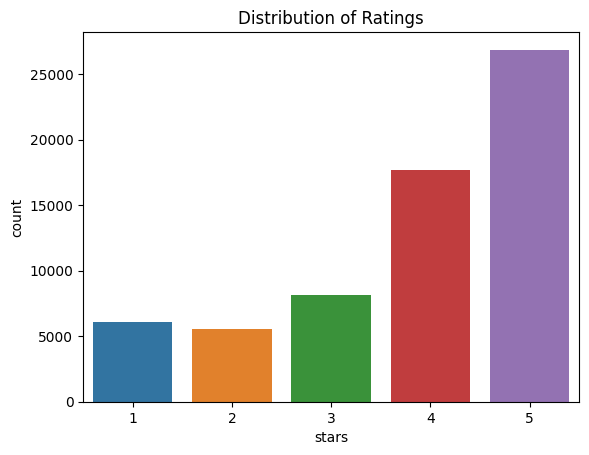

In [23]:
import seaborn as sns
plt.title('Distribution of Ratings')
sns.countplot(data=df_final, x = 'stars')

## Comparing Text Length to Stars

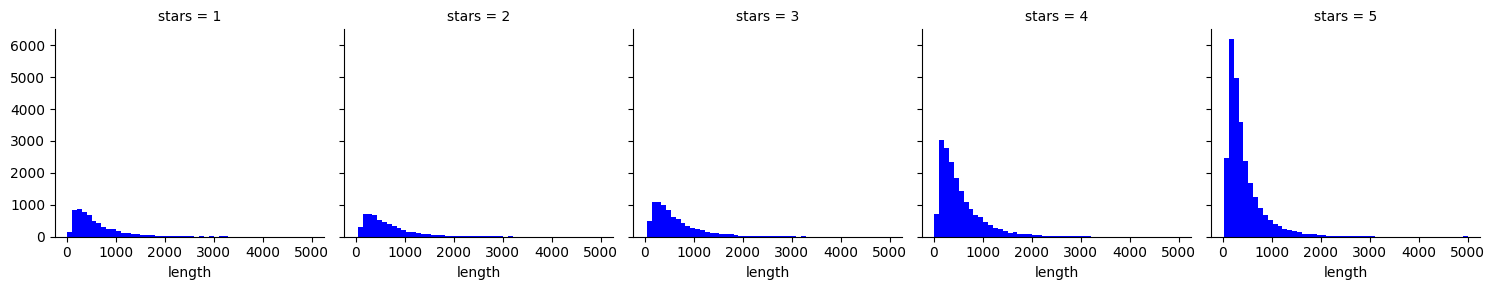

In [24]:
graph = sns.FacetGrid(data=df_final,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

## Visualizing the distribution of Review Lenghts

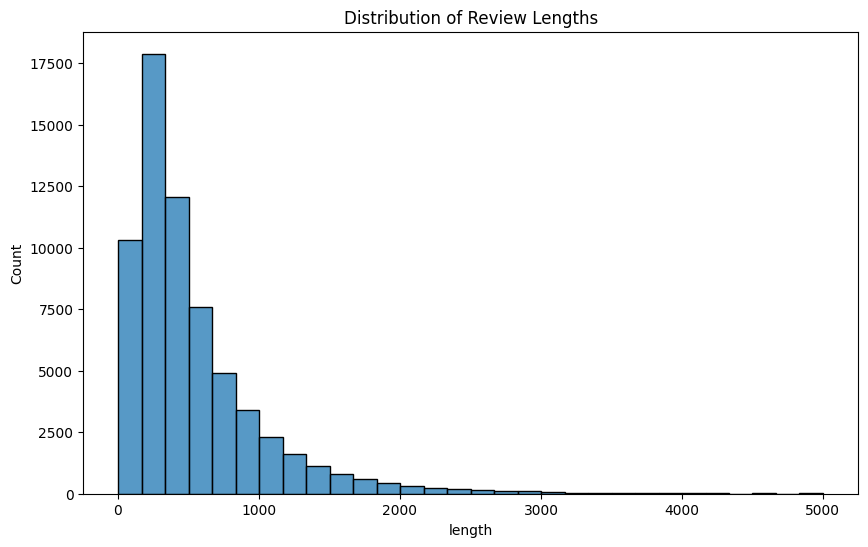

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(df_final['length'], bins=30)
plt.title('Distribution of Review Lengths')
plt.show()

## Correlation Analysis

<ipython-input-26-51d4e63298bf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_final.corr()


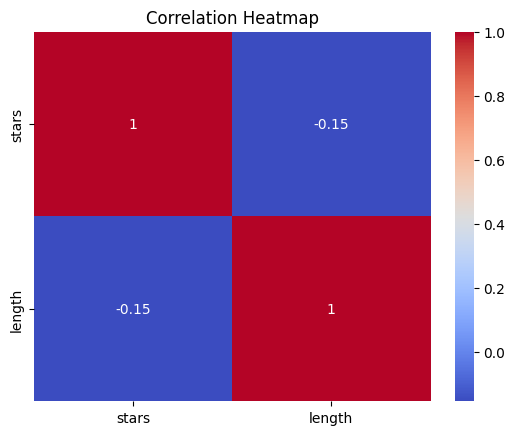

In [26]:
corr = df_final.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Burger King Analysis

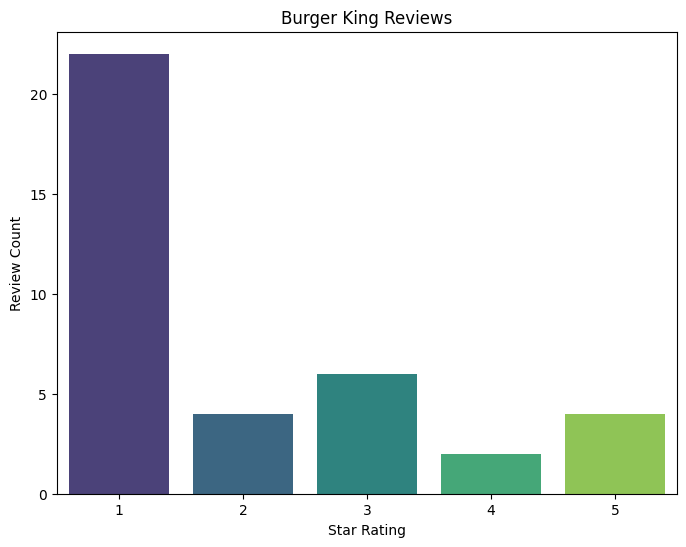

In [27]:
burger_king_reviews = df_final[df_final['name'] == 'Burger King'] #Looking at Burger king to see it's reviews
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=burger_king_reviews, palette='viridis')
plt.title('Burger King Reviews')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')
plt.show()

In [41]:
df_final.text[2]

'The place is cute and the staff was very friendly. Nice menu. Good for brunch. We had lunch and were seated right away. I really enjoyed the avocado  toast and side of bacon. Nice to have another brunch place nearby.'

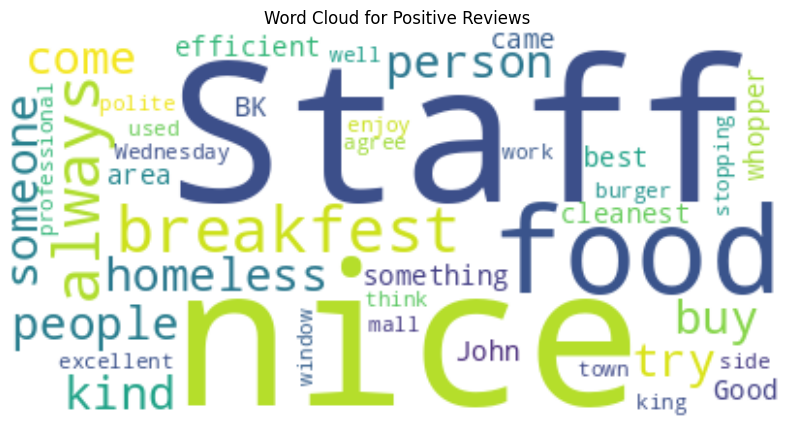

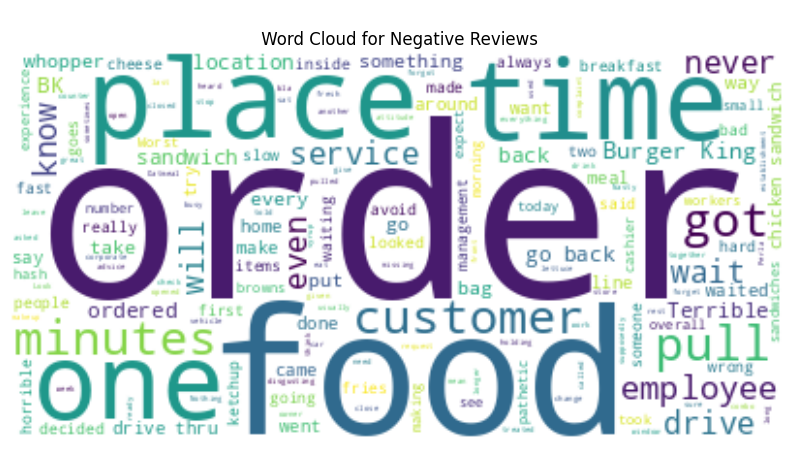

In [28]:
from wordcloud import WordCloud
positive_reviews = burger_king_reviews[burger_king_reviews['stars'] == 5]['text']
negative_reviews = burger_king_reviews[burger_king_reviews['stars'] == 1]['text']


# WORD CLOUD FOR POSITIVE REVIEWS
wordcloud_pos = WordCloud(background_color='white').generate(" ".join(positive_reviews))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# WORD CLOUD FOR NEGATIVE REVIEWS
wordcloud_neg = WordCloud(background_color='white').generate(" ".join(negative_reviews))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('\n Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()


# Review Text Processing

## Pre-Processing our Reviews as a feature and our Target variable

In [29]:
# Seperate the dataset into X and Y for prediction
x = df_final['text']
s = df_final['stars']
l = df_final['length']
print(x.head())
print(s.head())

0    If you decide to eat here, just be aware it is...
1    This is the second time we tried turning point...
2    The place is cute and the staff was very frien...
3    We came on a Saturday morning after waiting a ...
4    Mediocre at best. The decor is very nice, and ...
Name: text, dtype: object
0    3
1    2
2    4
3    3
4    2
Name: stars, dtype: int64


## Tokenizing Data

We'll use tokenizer library in order to split each individual word into a token. We will apply NLTK.word_tokenize() function to the reviews.

In [30]:
nltk.download('punkt')
x = x.apply(word_tokenize)
x.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [If, you, decide, to, eat, here, ,, just, be, ...
1    [This, is, the, second, time, we, tried, turni...
2    [The, place, is, cute, and, the, staff, was, v...
3    [We, came, on, a, Saturday, morning, after, wa...
4    [Mediocre, at, best, ., The, decor, is, very, ...
Name: text, dtype: object

## Converting all Characters to Lowercase
Transforming all words to lowercase is an important pre-processing step. In this case, we will transform all the tokenized words into lowercase. However, because we have to iterate over multiple words we will use a simple for-loop within a lambda function to apply the “lower” function to each word.

In [31]:
x = x.apply(lambda x: [word.lower() for word in x])
x.head()

0    [if, you, decide, to, eat, here, ,, just, be, ...
1    [this, is, the, second, time, we, tried, turni...
2    [the, place, is, cute, and, the, staff, was, v...
3    [we, came, on, a, saturday, morning, after, wa...
4    [mediocre, at, best, ., the, decor, is, very, ...
Name: text, dtype: object

## Removing Punctuations
Punctuation is often removed from our corpus since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters. It might be a little difficult to see but the tokenized punctuations in reviews has been removed.

In [32]:
punc = string.punctuation
x = x.apply(lambda x: [word for word in x if word not in punc])
x.head()

0    [if, you, decide, to, eat, here, just, be, awa...
1    [this, is, the, second, time, we, tried, turni...
2    [the, place, is, cute, and, the, staff, was, v...
3    [we, came, on, a, saturday, morning, after, wa...
4    [mediocre, at, best, the, decor, is, very, nic...
Name: text, dtype: object

## Removing Stopwords
Stopwords are typically useless words and do not add much meaning to a sentence. In the English language common stopwords include “you, he, she, in, a, has, are, etc.”

We are going to remove punctuations and other characters used for grammar using regex

In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
x = x.apply(lambda x: [word for word in x if word not in stop_words])
x.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [decide, eat, aware, going, take, 2, hours, be...
1    [second, time, tried, turning, point, location...
2    [place, cute, staff, friendly, nice, menu, goo...
3    [came, saturday, morning, waiting, months, ope...
4    [mediocre, best, decor, nice, like, restaurant...
Name: text, dtype: object

In [34]:
# Convert each list to a continuous string and create a new column
x = x.apply(lambda row: ' '.join(row))

# Print the updated DataFrame
print(x[0])

decide eat aware going take 2 hours beginning end tried multiple times want like 's locations nj never bad experience food good takes long time come waitstaff young usually pleasant many experiences spent way long waiting usually opt another diner restaurant weekends order done quicker


In [35]:
from tqdm import tqdm
from nltk.corpus import stopwords

processed_x = []
for i in tqdm(x):
    # print(i)
    #Regular expression that removes all the html tags pressent in the body
    i=re.sub('(<[\w\s]*/?>)'," ",i)
    #Expanding all the contractions present in the body to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+'," ",i)
    #Removing all the digits present in the body text
    i=re.sub('\d+'," ",i)
    i=re.sub(' +', ' ', i)


    #Making all the  text to be of lower case as well as remvoing the stopwords and words of length less than 3
    processed_x.append(" ".join([j.lower().translate(str.maketrans('', '', string.punctuation)) for j in i.split() if len(j)>=3]))


100%|██████████| 64282/64282 [00:18<00:00, 3463.27it/s]


In [36]:
processed_x[0]

'decide eat aware going take hours beginning end tried multiple times want like locations never bad experience food good takes long time come waitstaff young usually pleasant many experiences spent way long waiting usually opt another diner restaurant weekends order done quicker'

In [37]:
len(processed_x)

64282

In [38]:
final_df = pd.DataFrame({'Reviews': processed_x, 'Rating':s, 'Rev_len': l})

In [39]:
final_df

,Reviews,Rating,Rev_len
0,decide eat aware going take hours beginning en...,3,513
1,second time tried turning point location first...,2,477
2,place cute staff friendly nice menu good brunc...,4,216
3,came saturday morning waiting months opening h...,3,736
4,mediocre best decor nice like restaurant tryin...,2,953
...,...,...,...
99943,mind fast food restaurants generally high expe...,2,613
99950,supposedly burger king open midnight pull driv...,1,199
99969,interesting experience wow start eat food orde...,1,1419
99976,safe clean food easy access really needed prot...,3,155


In [40]:
df = pd.DataFrame(final_df)

csv_file_path = '/content/drive/MyDrive/Data690 Project/Cleaned_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"DataFrame exported to {csv_file_path}")

DataFrame exported to /content/drive/MyDrive/Data690 Project/Cleaned_data.csv
